## Analyze A/B Test Results

Eze Ahunanya

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction



For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
n_rows = df.shape[0]
n_rows

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Store new dataframe in **df2**.

In [8]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(subset='user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep dataframe as **df2**.

In [13]:
df2.drop_duplicates(subset='user_id', keep='first', inplace=True)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
df2[df2.duplicated(subset='user_id')].count()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`4.` Use **df2** in the below cells.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
old_conv = df2[(df2.group == 'control')].converted.mean()
old_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
new_conv = df2[(df2.group == 'treatment')].converted.mean()
new_conv

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2[(df2.landing_page == 'new_page')].shape[0]/(df2.shape[0])

0.5000619442226688

e. Consider the results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

- The overall conversion rate is 0.1196 (4 s.f.).
- The conversion rate from the new page is 0.1188 (4 s.f.) while the rate from the old page is 0.1204 (4 s.f.).
- These rates are very close although is does appear that the old page is better.
- However we do not know is these results are statistically significant.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2[df2.landing_page == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted_o = np.random.binomial(1, p_new, n_new)
p_new_o = new_page_converted_o.mean()
p_new_o

0.12111348152226274

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted_o = np.random.binomial(1, p_old, n_old)
p_old_o = old_page_converted_o.mean()
p_old_o

0.11821798807770145

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_new_o - p_old_o

0.0028954934445612895

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
new_page_converted = np.random.binomial(n_new, p_new, 10000)
old_page_converted = np.random.binomial(n_old, p_old, 10000)
p_diffs = new_page_converted/n_new - old_page_converted/n_old
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

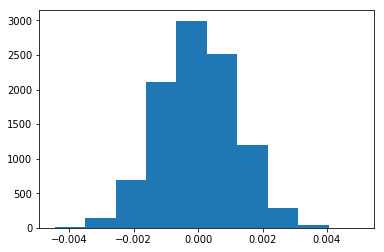

In [27]:
plt.hist(p_diffs);

In [28]:
obs_diff = new_conv - old_conv
obs_diff

-0.0015782389853555567

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
(p_diffs > obs_diff).mean()

0.9097

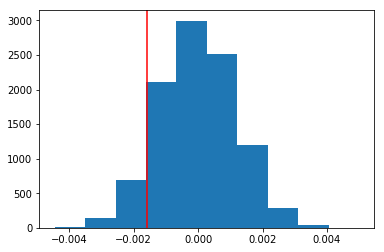

In [30]:
#Plotting the observed statistic on the histgram, the p-value is the area on the right of the line
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='red');

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- In part j the p-value for the difference in the conversion rate of the two pages was calculated.
- This was done by finding the proportion of values in the difference array (p_diffs) from the sample distribution (for if the null hypothesis was true) were greater than the observed difference in the data.
- This is the probability of observing the difference statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.
- As the probility of 0.9082 is high the statistic was more likely to come from the null distribution and hence we fail to reject the null hypothesis as there isn't evidence to reject it.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
# import statsmodels.api as sm
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
sm.stats.proportions_ztest(count=[convert_new, convert_old], nobs=[n_new, n_old], value=0, alternative = 'larger')

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- The z-score is a measure of standard deviation which has a value of approximately -1.311. A very high modulus of the standard deviation is associated with a low p-value and a decreased likelyhood that the statistic originated for the conditions of the null hypothesis. 
- These results agree with part j are the p-values are the to 2 significant figues at 0.91. This means there is not enough evidence to reject the null hypothesis and the old page is likely to be better than the new one.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression as the response variable (conversion) is categorical and only has two possible outcomes.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [34]:
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']
df2['intercept'] = 1

df2.head()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 19 Oct 2019   Pseudo R-squ.:               8.077e-06
Time:                        02:19:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
#Need to exponentiate the value in order to interpret them.
np.exp(-1.9888), np.exp(-0.0150)

(0.13685955841614492, 0.9851119396030626)

In [37]:
#For values below 1 the reciprocal is easier to relate to
1/np.exp(-1.9888), 1/np.exp(-0.0150)

(7.3067603868728614, 1.015113064615719)

- If the person received the old page, conversion is 1.015 times as likely compared to the new page holding all else constant.
- The p-value of 0.19 is bigger than 0.05 meaning the relationship is not significant and that there probably is not much of a relationship between the variables.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

- The p-value associated with ab_page is 0.19.
- In part II, the null is the old page had an equal or better conversion rate than the new page so it was a one sided calculation. The p-value was only concerned with the probaility of the new page having a greater conversion rate than the old page.
- However in part III, the null is there is no effect from the variables on the response. So to prove the alternative that there is an effect both directions need to be tested so it is a two sided test. This explains why the p-value is smaller as it just includes the extremities of the tails on each end of the distribution. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- There may be other factors that is not encorperated by the data which could also have an effect on the response variable (converted) allowing the relationship to be better understood.
- When multiple factors are included into the regression some become less significant compared to if they were viewed by itself. This highlights which are the most important variables which have an effect on the response. 

There can be disadvantages such as:
- No linear relationship.
- Correlated errors. Correlated errors frequently occur when data is collected over time or data are spatially related.
- Non-constant variance. Non-constant variance is when the spread of your predicted values differs depending on which value you are trying to predict. It can lead to confidence intervals and p-values that are inaccurate.
- Outliers. Outliers and leverage points are points that lie far away from the regular trends of your data. These points can have a large influence on the solution.
- Multicollinearity. Multicollinearity is when we have predictor variables that are correlated with one another. One of the main concerns of multicollinearity is that it can lead to coefficients being flipped from the direction we expect from simple linear regression.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [39]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new.country)
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [41]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 19 Oct 2019   Pseudo R-squ.:               1.521e-05
Time:                        02:19:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

In [42]:
#Need to exponentiate the value in order to interpret them.
np.exp(0.0408), np.exp(0.0507)

(1.0416437559600236, 1.052007243765014)

- If the person is from the US conversion is 1.042 times as likely compared to canada, holding all else constant.
- If the person is from the UK conversion is 1.052 times as likely compared to canada, holding all else constant.

All of the p-values are above 0.05 so none are significant meaning we fail to reject the null. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 19 Oct 2019   Pseudo R-squ.:               2.323e-05
Time:                        02:20:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [44]:
#Need to exponentiate the value in order to interpret them.
np.exp(-0.0149), np.exp(0.0408), np.exp(0.0506)

(0.9852104557227469, 1.0416437559600236, 1.0519020483004984)

In [45]:
#For values below 1 the reciprocal is easier to relate to
1/np.exp(-0.0149)

1.0150115583846535

- If the person received the old page, conversion is 1.015 times as likely compared to the new page holding all else constant.
- If the person is from the US conversion is 1.042 times as likely compared to canada, holding all else constant.
- If the person is from the UK conversion is 1.052 times as likely compared to canada, holding all else constant.

All of the p-values are above 0.05 so none are significant meaning we fail to reject the null. This means there is likely no relationship between these variables and theres is no difference between the pages.

<a id='conclusions'></a>
## Conclusions

Based on the logistic regression there are no statistically significant results between the independent variables, ab_page and countries, and the response variable, conversion, independently or in conjunction together. All the p-values calculated were greater than 0.05 resulting in failing to reject the null hypothesis. There is no evidence that the new page has a higher conversion rate than the new page and therefore the old page should be continued to be used. The AB test could be run for longer to gather more data.